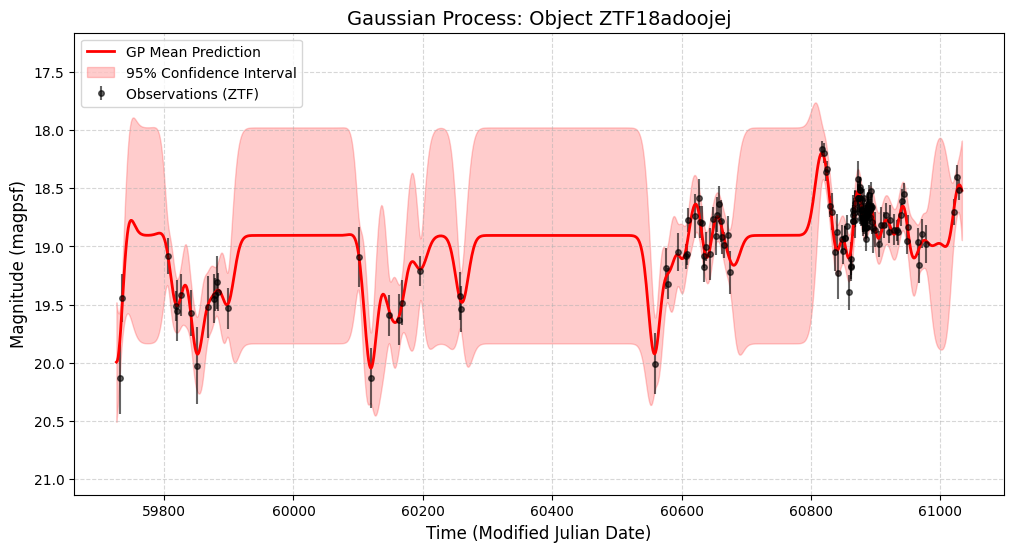

Optimized Kernel: 1.3**2 * RBF(length_scale=10) + WhiteKernel(noise_level=0.0643)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# 1. Load astronomical data
# Using the supernova sample ZTF18adoojej
df = pd.read_csv("../data/ZTF18adoojej_detections.csv")

# Filtering for g-band (fid=1) to simplify the first regression
filter_g = df[df['fid'] == 1].sort_values('mjd')

X = filter_g['mjd'].values.reshape(-1, 1) # Feature: Time in MJD
y = filter_g['magpsf'].values             # Target: Magnitude
y_err = filter_g['sigmapsf'].values       # Observational noise (errors)

# 2. Kernel Definition
# ConstantKernel (C) scales the magnitude
# RBF (Radial Basis Function) defines the smoothness of the curve
# WhiteKernel accounts for the intrinsic noise in the telescope measurements
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=10.0, length_scale_bounds=(1e-1, 100.0)) + \
         WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1.0))

# 3. Model Initialization
# alpha=y_err**2 incorporates the heteroscedastic noise (different error for each point)
gp = GaussianProcessRegressor(
    kernel=kernel, 
    alpha=y_err**2, 
    normalize_y=True, 
    n_restarts_optimizer=10
)

X_scaled = X - X.min()

# 4. Fitting the model to the data
gp.fit(X_scaled, y)

# 5. Generating a dense time grid for interpolation and prediction
x_grid = np.linspace(X.min() - 5, X.max() + 5, 1000).reshape(-1, 1)
x_grid_scaled = x_grid - X.min()
y_pred, sigma = gp.predict(x_grid_scaled, return_std=True)

# 6. Improved Visualization
plt.figure(figsize=(12, 6))

# Plotting
plt.errorbar(X, y, yerr=y_err, fmt='ok', markersize=4, label='Observations (ZTF)', alpha=0.6)
plt.plot(x_grid, y_pred, 'r-', lw=2, label='GP Mean Prediction')
plt.fill_between(x_grid.flatten(), 
                 y_pred - 1.96 * sigma, 
                 y_pred + 1.96 * sigma, 
                 color='red', alpha=0.2, label='95% Confidence Interval')

# --- Improved Dynamic Axis Scaling ---
# We use the GP prediction and its uncertainty to define the view
# This ensures the red "cloud" is always visible
y_upper_bound = (y_pred + 1.96 * sigma).max() + 0.5 # Lowest brightness (highest mag)
y_lower_bound = (y_pred - 1.96 * sigma).min() - 0.5 # Highest brightness (lowest mag)

# --- Scaling for Astronomy ---
# We focus on the actual observations (y), not the theoretical uncertainty
# to prevent "plashing" the data.
padding = 1.0 
plt.ylim(y.max() + padding, y.min() - padding)


plt.xlabel("Time (Modified Julian Date)", fontsize=12)
plt.ylabel("Magnitude (magpsf)", fontsize=12)
plt.title(f"Gaussian Process: Object ZTF18adoojej", fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

# Print the optimized kernel parameters
print(f"Optimized Kernel: {gp.kernel_}")

In [9]:
# Check one processed file
check_df = pd.read_csv("../data/processed/ZTF18adoojej_detections_processed.csv")

print(f"Shape: {check_df.shape}") # Should be (200, 5) if both filters passed
print(check_df.head())

# Quick check on the number of points per filter
print(check_df['filter_id'].value_counts())

Shape: (200, 5)
                 object_id  filter_id  relative_time   mag_pred     sigma
0  ZTF18adoojej_detections          1       0.000000  19.831233  0.143296
1  ZTF18adoojej_detections          1      13.098293  18.848555  0.371309
2  ZTF18adoojej_detections          1      26.196586  18.848769  0.471903
3  ZTF18adoojej_detections          1      39.294880  18.903270  0.473779
4  ZTF18adoojej_detections          1      52.393173  18.898655  0.471858
filter_id
1    100
2    100
Name: count, dtype: int64
